# SPI Momentum

In this project, we investigate whether the long only momentum effect, first documented by Jegadeesh and Titman (1993), persists in Switzerland to this day and to what extent it can generate abnormal net returns.

### Setup and Dependencies


In [21]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings

# Add the project root directory to sys.path
project_root = Path(os.getcwd()).resolve().parents[0]
#DEBUG print(project_root)
sys.path.append(str(project_root))

# Load other funcitons
from src.analysis.load_data import load_data
from src.visualization.plotPerformance import plot_cumulative_returns
from src.visualization.plotRobustnessChecks import plotRobustnessChecks
from src.analysis.summarize_performance import summarize_performance, save_summary_to_latex
from src.analysis.momentum_strategy_backtest import momentum_strategy
from src.visualization.create_summary_table import create_summary_table

from src.analysis.robustness_checks import run_holding_period_check
from src.analysis.robustness_checks import run_lookback_period_check
from src.analysis.robustness_checks import run_number_assets_check
from src.analysis.robustness_checks import run_trx_cost_check


warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Import and Overview

Data (SPI constituents total returns, risk free rate and SPI index data) will be loaded from a csv file. In case you wish to replace the data with your own data, simply replace the data in the data folder by data using the same structure.

In [7]:
# Define the base path for file locations
base_path = project_root

# Construct file paths dynamically
constituents_data_path = base_path / "data" / "processed" / "constituents_data.csv"
rf_monthly_path = base_path / "data" / "processed" / "risk_free.csv"
results_path = base_path / "data" / "results"
spi_path = base_path / "data" / "processed" / "index_data.csv"
summary_file_path_longOnly = results_path / "summary_performance_longOnly.tex"
summary_file_path_longShort = results_path / "summary_performance_longShort.tex"
visualization_path = base_path / "reports" / "figures"

# Load financial data
rf_monthly = load_data(rf_monthly_path)
price_data_daily = load_data(constituents_data_path)
spi_price_daily = load_data(spi_path)
spi_price_monthly = spi_price_daily.resample('ME').last()

# Calculate Benchmark Returns and correct for massive outliers
spi_returns_monthly = spi_price_monthly.pct_change()
if isinstance(spi_returns_monthly, pd.Series):
    spi_returns_monthly = spi_returns_monthly.to_frame()
spi_returns_monthly = np.clip(spi_returns_monthly, -0.5, 0.5)
spi_XsReturns_monthly = spi_returns_monthly['SWISS PERFORMANCE INDEX - TOT RETURN IND'] - rf_monthly['monthly_return']
if isinstance(spi_XsReturns_monthly, pd.Series):
    spi_XsReturns_monthly = spi_XsReturns_monthly.to_frame()

# Rename Coluns for consistency
spi_XsReturns_monthly.columns = ['Benchmark']
spi_returns_monthly.columns = ['Benchmark']

### Set up Basic Parameters for Analysis

Since the project is fully reproducable, we decided to include the most important strategy paratemers on this level so that any potential future researcher can simply change the parameters for the analysis here. As a basic set up we chose to use the parameters as listed below. Of course, there will be rubustness checks for all those parameters at the end. 

In [11]:
lookback_period = 6    # Number of months to look back
holding_period = 6     # Number of months the assets will be held
nLong = 20             # Number of assets to go long
nShort = 20            # Number of assets to short
trx_cost = 0           # Transaction Costs (i.e. 0.01 = 1%)

### Momentum Analysis
In this section we run the Momentum backtest accoring to the approach of Jegadeesh and Titman (1993). We test a long only and a long-short portfolio and compare it with the overall SPI index.

Save the summarize performance plot to /Users/steve/Documents/Coding/my-project/SPI-Momentum/reports/figures/cumulative_returns


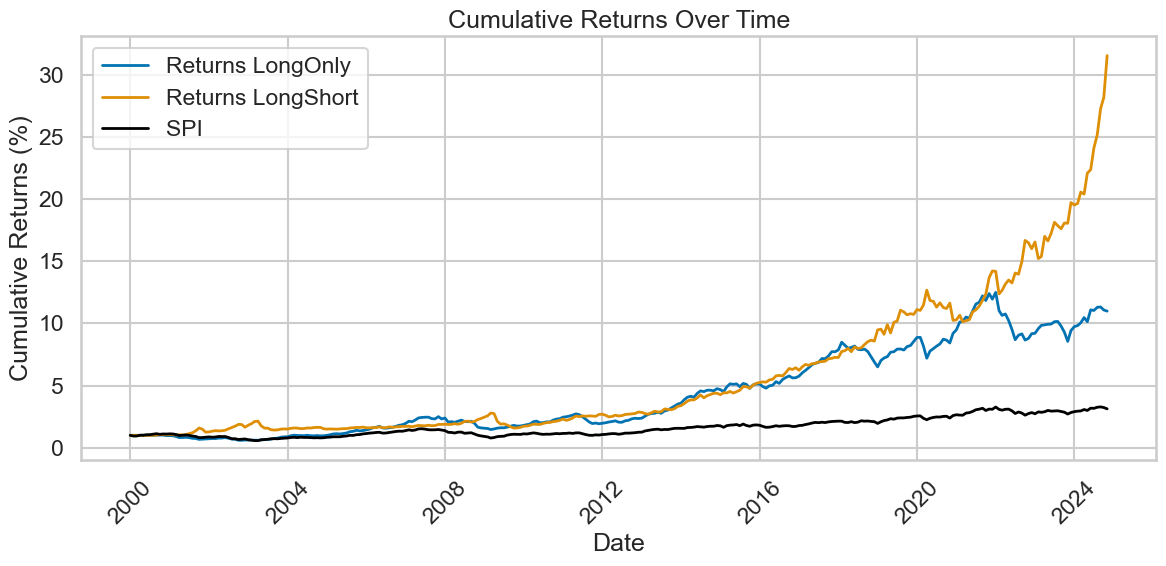

In [14]:
# ----- Execute Long only backtest -----
excess_returns_longOnly, portfolio_weights_longOnly, turnover_series_longOnly, portfolio_returns_longOnly = momentum_strategy(
    price_data_daily=price_data_daily,
    lookback_period=lookback_period,
    nLong=nLong,
    nShort=0,
    holding_period=holding_period,
    rf_monthly=rf_monthly,
    trx_cost=0
)
excess_returns_longOnly.columns = ['Xs Returns LongOnly']
portfolio_returns_longOnly.columns = ['Returns LongOnly']

# Save results to a csv file for closer inspection
excess_returns_longOnly.to_csv(results_path / "excess_returns_longOnly.csv", index=True, header=True)
portfolio_weights_longOnly.to_csv(results_path / "portfolio_weights_longOnly.csv", index=True, header=True)
turnover_series_longOnly.to_csv(results_path / "turnover_series_longOnly.csv", index=True, header=True)
stats_longOnly = summarize_performance(excess_returns_longOnly, rf_monthly, spi_XsReturns_monthly, 12)
save_summary_to_latex(stats_longOnly, summary_file_path_longOnly)

# ----- Execute Long / Short backtest -----
excess_returns_longShort, portfolio_weights_longShort, turnover_series_longShort, portfolio_returns_longShort = momentum_strategy(
    price_data_daily=price_data_daily,
    lookback_period=lookback_period,
    nLong=nLong,
    nShort=nShort,
    holding_period=holding_period,
    rf_monthly=rf_monthly,
    trx_cost=0
)
excess_returns_longShort.columns = ['Xs Returns LongShort']
portfolio_returns_longShort.columns = ['Returns LongShort']

# Save results to a csv file for closer inspection
excess_returns_longShort.to_csv(results_path / "excess_returns_longShort.csv", index=True, header=True)
portfolio_weights_longShort.to_csv(results_path / "portfolio_weights_longShort.csv", index=True, header=True)
turnover_series_longShort.to_csv(results_path / "turnover_series_longShort.csv", index=True, header=True)
stats_longShort = summarize_performance(excess_returns_longShort, rf_monthly, spi_XsReturns_monthly, 12)
save_summary_to_latex(stats_longShort, summary_file_path_longShort)


# Custom labels
labels = {
    'Strategy_Returns': 'Long Momentum Strategy',
    'Benchmark': 'SPI',
    'Portfolio_Returns': 'Long Momentum Strategy',
    'xs_Return': 'Long Momentum Strategy',
    'trx_cost_0.001': 'Strategy with Trx Cost: 0.1%',
    'trx_cost_0.005': 'Strategy with Trx Cost: 0.5%',
    'trx_cost_0.01': 'Strategy with Trx Cost: 1.0%',
}

# Create plot of cummulative returns against benchmark
combined_returns = pd.concat([portfolio_returns_longOnly, portfolio_returns_longShort], axis=1)
plot_cumulative_returns(combined_returns, spi_returns_monthly, labels,filename=visualization_path / "cumulative_returns")


In [33]:
# Table with stats:
stats_bm = summarize_performance(spi_XsReturns_monthly, rf_monthly, spi_XsReturns_monthly, 12)
create_summary_table([stats_longOnly, stats_longShort, stats_bm], ['Long Only', 'Long Short', 'SPI'])



,Long Only,Long Short,SPI
Arithmetic Avg Total Return,10.8041,17.0147,2.4043
Arithmetic Avg Excess Return,8.9813,15.1918,0.4947
Geometric Avg Total Return,10.0953,16.9436,1.4619
Geometric Avg Excess Return,8.2598,15.1080,-0.4619
Std of Excess Returns (Annualized),0.1517,0.1575,0.1388
Sharpe Ratio (Arithmetic),0.5919,0.9644,0.0356
Sharpe Ratio (Geometric),0.5443,0.9591,-0.0333
Min Excess Return,-0.1627,-0.2251,-0.1302
Max Excess Return,0.0990,0.1612,0.1202
Skewness of Excess Return,-0.7074,-0.8737,-0.4670


### Robustness Checks
In this section we perform robustness checks over different input parameters that we have chosen "arbitrarily". Those parameters are lookback period, holding period, nLong/nShort, trx cost

RC of Holding Period
   Sharpe_Ratio
1      0.728561
2      0.721183
3      0.656974
4      0.619744
5      0.590739
6      0.591893
7      0.572669
8      0.548206
9      0.526518
10     0.511345
11     0.496805
12     0.471127


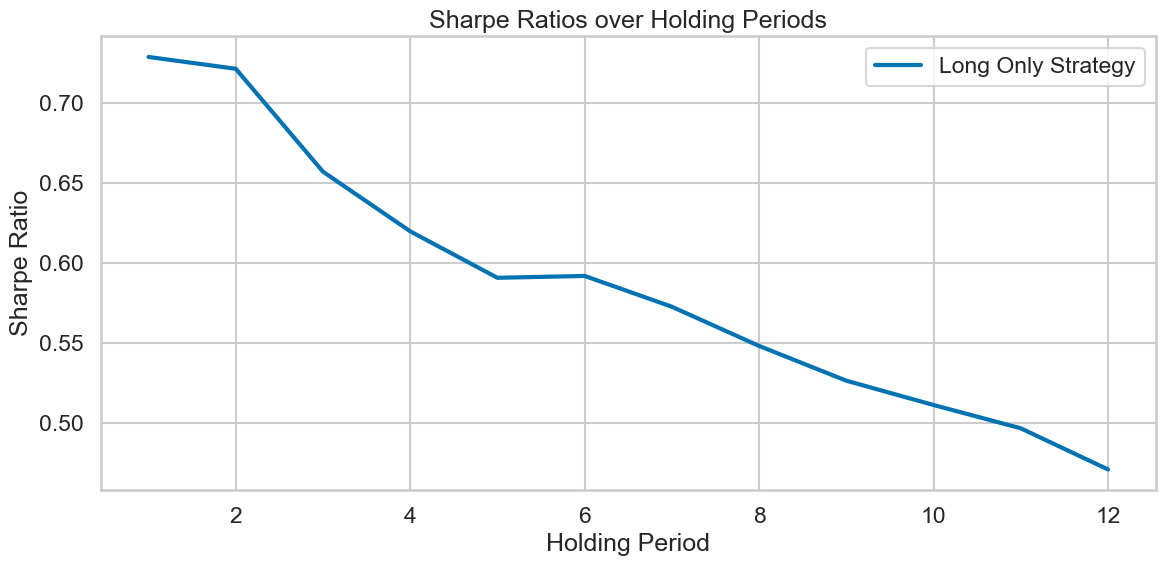

RC of Lookback Period
   Sharpe_Ratio
1        0.3889
2      0.507649
3      0.568293
4      0.594069
5      0.565171
6      0.591893
7      0.629542
8      0.649846
9      0.667371
10     0.692819
11     0.677207
12     0.666711


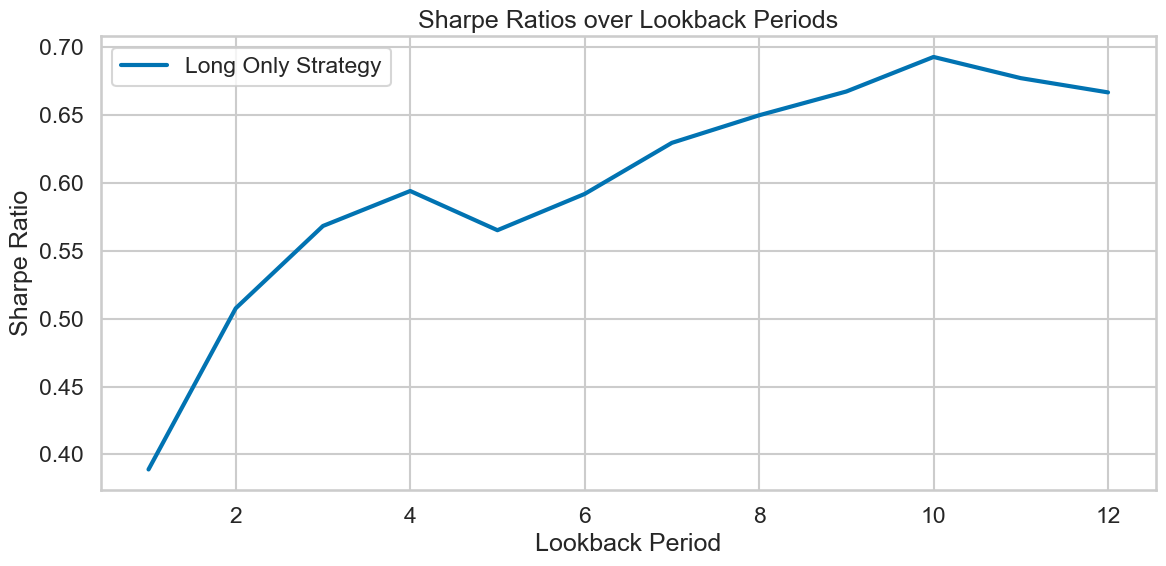

RC of Number Assets
   Sharpe_Ratio
5      0.585034
6      0.613569
7      0.621705
8      0.613726
9      0.604134
10     0.621299
11     0.616764
12     0.626944
13     0.611398
14     0.585354
15     0.589083
16     0.599135
17     0.588957
18     0.592361
19     0.589504
20     0.591893
21     0.592835
22     0.597323
23     0.598418
24     0.603365
25     0.597969
26     0.605466
27     0.605505
28     0.597006
29      0.59485
30     0.600982
31     0.607711
32     0.608236
33     0.615886
34     0.620221
35     0.619808
36     0.629247
37     0.635004
38     0.640096
39     0.646853
40       0.6508
41     0.642999
42     0.641667
43     0.637219
44     0.630004
45     0.628223
46     0.629933
47     0.630067
48      0.62885
49     0.628627
50     0.630253


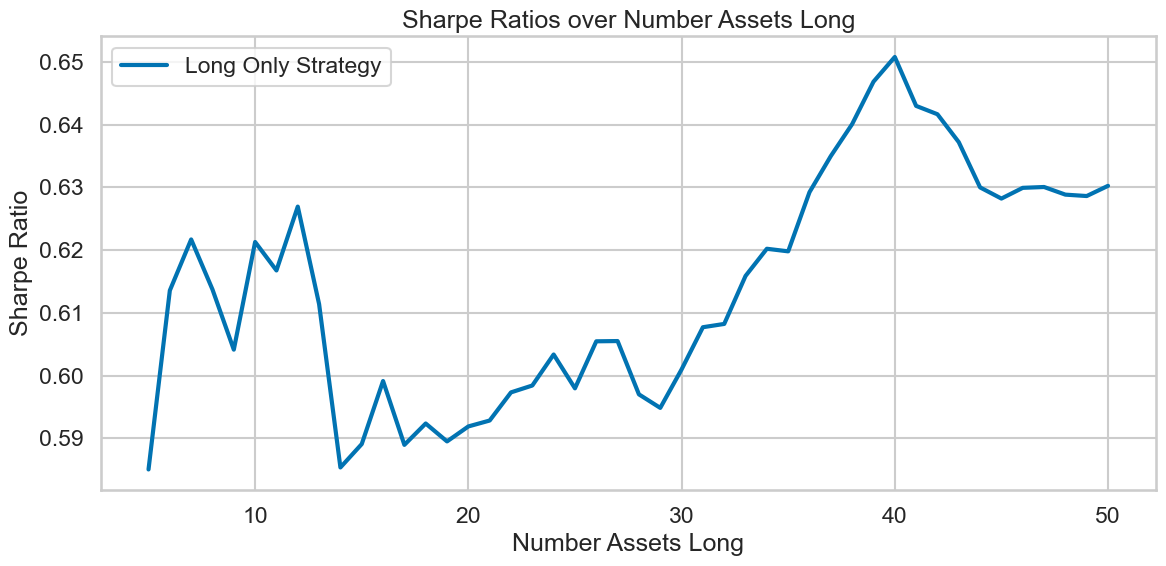

Save the summarize performance plot to /Users/steve/Documents/Coding/my-project/SPI-Momentum/reports/figures/rc_trxCost.png


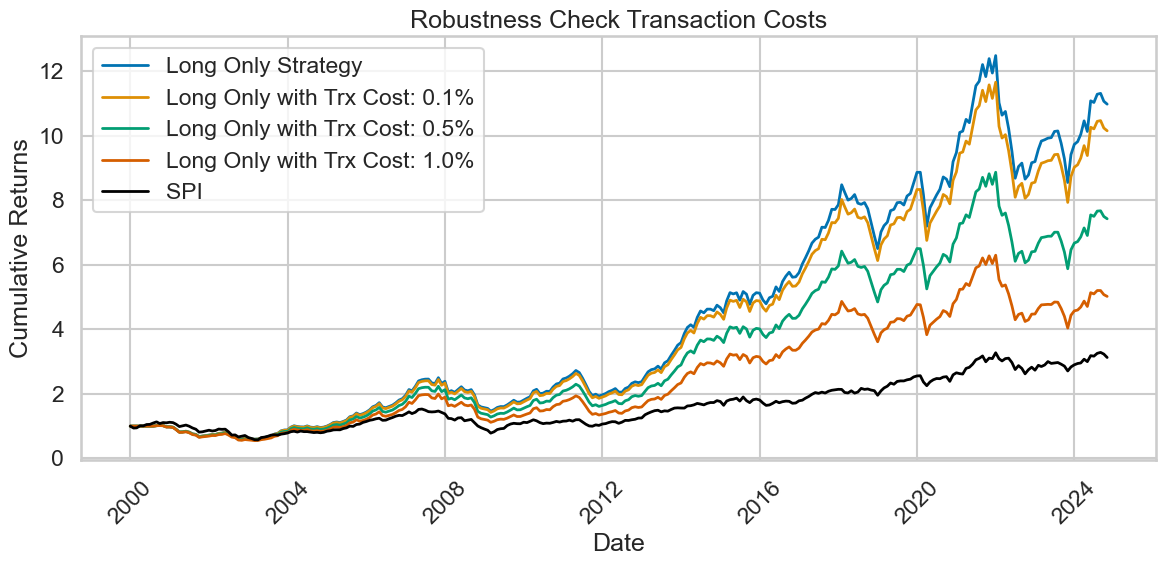

RC of Transaction Costs
            Strategy_Returns  trx_cost_0.001  trx_cost_0.005  trx_cost_0.01
date                                                                       
1999-12-31          0.000000        0.000000        0.000000       0.000000
2000-01-31          0.000000        0.000000        0.000000       0.000000
2000-02-29          0.000000        0.000000        0.000000       0.000000
2000-03-31          0.000000        0.000000        0.000000       0.000000
2000-04-30          0.000000        0.000000        0.000000       0.000000
...                      ...             ...             ...            ...
2024-06-30         -0.004558       -0.004825       -0.005891      -0.007225
2024-07-31          0.023050        0.022800        0.021800       0.020550
2024-08-31          0.002461        0.002195        0.001128      -0.000205
2024-09-30         -0.021628       -0.021895       -0.022961      -0.024295
2024-10-31         -0.008090       -0.008357       -0.009423    

In [31]:
# Robustness checks over holding period
run_holding_period_check(price_data_daily, lookback_period, nLong, rf_monthly, spi_XsReturns_monthly, visualization_path)


In [ ]:
# Robustness checks over lookback period
run_lookback_period_check(price_data_daily, range(1,13), nLong, 0, holding_period, rf_monthly, spi_XsReturns_monthly, visualization_path)

In [ ]:
# Robustness checks over number assets
run_number_assets_check(price_data_daily, lookback_period, range(5,51), 0, holding_period, rf_monthly, spi_XsReturns_monthly, visualization_path)

In [ ]:
# Robustness checks over transaction costs
run_trx_cost_check(price_data_daily, lookback_period, nLong, 0, holding_period, rf_monthly, spi_returns_monthly, visualization_path)